# PolytechNice2023 DL 4 media competition

Team: Marina & Ewa

# Introduction

### 1. Import libraries

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import torchvision.utils as vutils
!pip install torchsummary
from torchsummary import summary
import torch.nn as nn

import pandas as pd
import numpy as np
import random

from PIL import Image
import matplotlib.pyplot as plt

import shutil

import csv

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from tqdm import tqdm


# Define path to folder and CSV file
train_path = '/kaggle/input/polytechnice2023-deep-learning-competition/train_images/'
test_path = '/kaggle/input/polytechnice2023-deep-learning-competition/test_images/'
csv_path = '/kaggle/input/polytechnice2023-deep-learning-competition/train.csv'

### 2. Check GPU

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

### 3. Unbalance data


We display the frequency of every class to check if our dataset is unbalanced. 

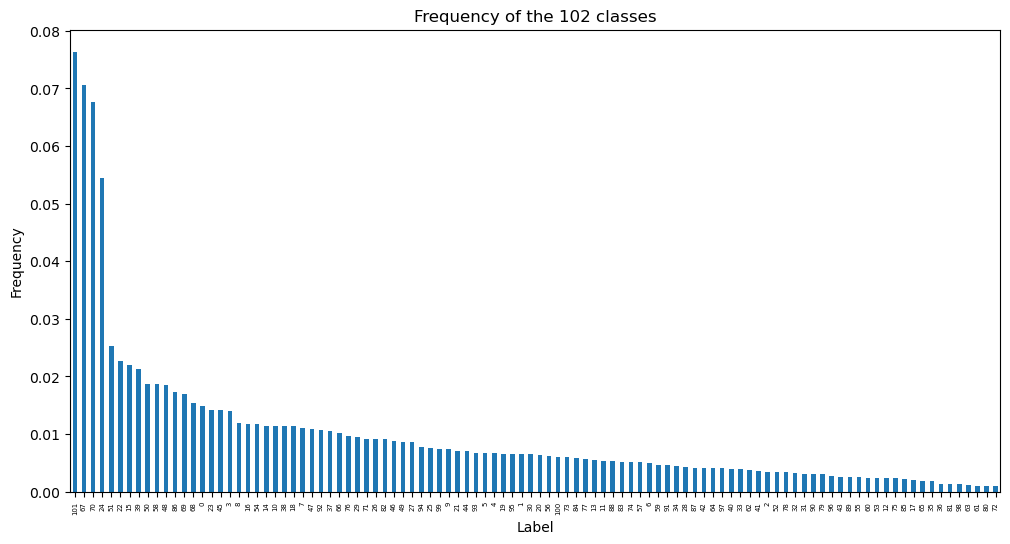

In [3]:
# Load the CSV file that contains the labels
df = pd.read_csv(csv_path)

# Sort dataframe by filenames
labels_df = df.sort_values(by='ID')
labels_df['y'] = labels_df['y'].astype(str)

# Get label distribution from DataFrame
label_distribution = labels_df['y'].value_counts(normalize=True)

top_n = 102
fig = plt.figure(figsize=(12, 6))
ax = label_distribution.head(top_n).plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=5)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title(f'Frequency of the 102 classes')
plt.show()

# Data 

The steps followed to load the data are:
- Load the filenames (from the train_images and the test_images folder) and the labels (from the train.csv file) in lists
- Split the data 80% for training and 20% for validation
- Define the transformations to be applied to the training and test images. We perform some data augmentation techniques to handle our unbalanced data (random horizontal and vertical flip, random rotation, brigtness) and some preprocessing (resize 224 x 224 pixels, conver to Pytorch tensor, normalize the pixels).
- Create a custom Pytorch dataset for loading, preprocessing and transforming image data
- Create dataloaders for the training,validation and testing datasets. 


### 1. Load filenames and labels

In [4]:
# Get a list of all the sorted file names in the training directory
file_names = sorted(os.listdir(train_path))

# Get a list of labels for each image in the training directory
labels = df['y'].tolist()

### 2. Split into training and validation set

In the train_test_split function, we use the stratify parameter to ensure that the same proportion of samples from each class is present in both the training and validation sets (useful when the dataset is unbalanced)

In [5]:
# Training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(file_names,labels,test_size=0.2,stratify=labels)

In [6]:
# Testing set
xTest = sorted(os.listdir(test_path))

### 3. Display a random image from a list

In [7]:
def plot_image(x, path, y=None, n=0):
    # choose a random index
    i = random.randrange(len(x))
    # select the corresponding elements from both lists
    img = x[i]
    img_path = os.path.join(path, img)
    image = Image.open(img_path).convert('RGB')                                             
    plt.imshow(image)
    if n ==0:
        label = y[i]
        plt.title(label)

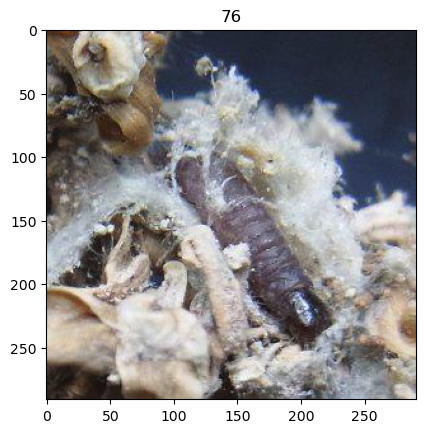

In [8]:
plot_image(xTrain,train_path,yTrain)

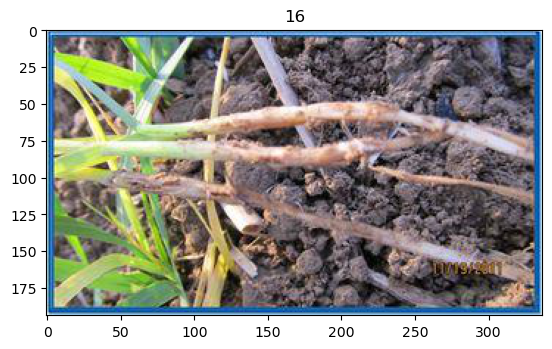

In [9]:
plot_image(xVal,train_path, yVal)

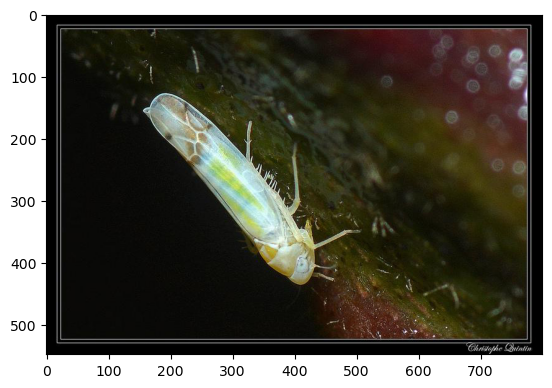

In [10]:
plot_image(xTest,test_path, n=1)

### 4. Create a custom dataset

In [11]:
# Define the transformations and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), #resizing the input image to the image of size 224X224
    transforms.RandomHorizontalFlip(p=0.2),#flipping the image with probability of 0,2 to help the model to generalize better  
    transforms.RandomVerticalFlip(p=0.2), #flipping the image vertically
    transforms.RandomRotation(degrees=20),#randomly rotating the images up to 20 degrees in different directions,we want to boost the variation in training data and form the model more resilient to rotated images. 
    transforms.ColorJitter(brightness=0.5),#changing the brightness of the image with the factor up to 0,5 to increase the differentiation in the training data 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #We take the mean and standard deviation calculated from the ImageNet dataset, to normalize the input tensor by removing the mean and dividing by the standard deviation. We want the input for the model has a zero mean and unit variance, which can enhance the model's performance.
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [12]:
# Custom dataset
class IP102TrainDataset(Dataset):
    def __init__(self, x, y, path, transform=None):
        self.img = x
        self.labels = y
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.img[idx])
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')   
        if self.transform:                                                                                       
            image = self.transform(image)
        return image, label
    
    
class IP102TestDataset(Dataset):
    def __init__(self, x, path, y=None, transform=None):
        self.img = x
        self.labels = y
        self.path = path
        self.transform = transform
        

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.img[idx])
        image = Image.open(img_path).convert('RGB')   
        if self.transform:                                                                                       
            image = self.transform(image)
        return image, self.img[idx]

In [13]:
train_dataset = IP102TrainDataset(xTrain, yTrain, train_path, transform=train_transform)
val_dataset = IP102TrainDataset(xVal, yVal, train_path, transform=test_transform)
test_dataset = IP102TestDataset(xTest, test_path, transform=test_transform)

### 7. Define dataloaders

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=128)

### 6. Display a random image from an instance of the dataloader

In [15]:
def display_dataloader(dataloader):
    # Get a batch of images from your dataloader
    batch = next(iter(dataloader))

    # Create a grid of images
    grid = vutils.make_grid(batch[0], nrow=8, padding=2, normalize=True)

    # Display the grid
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

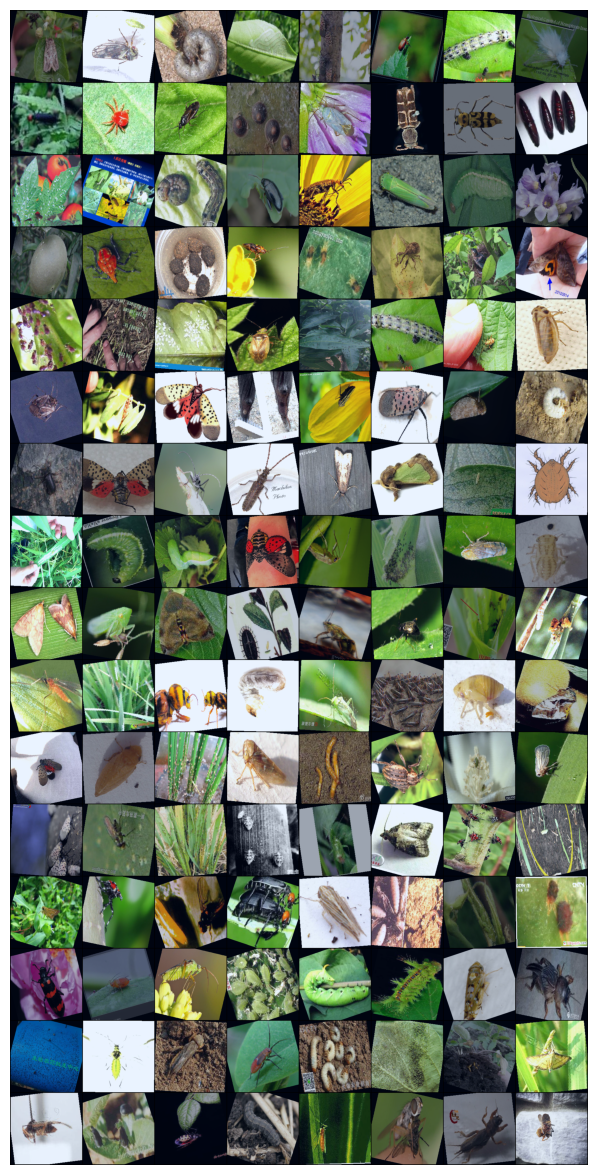

In [16]:
display_dataloader(train_dataloader)

# Network 

We decided to use ResNet50V2 architecture, which is a pre-trained model on ImageNet dataset.

Since the pre-trained model was trained on a different dataset, we need to add our own output layers to the model to adapt it for our specific task. 
Here, we add nn.Sequential that replaces the last fully connected layer of the ResNet50 model with a new sequence of layers that have a linear layer with 2048 input features and 256 output features. The  nn.ReLu is a layer with the ReLu activation function that introduces non-linearity to the model. What is more Dropout layer is used to avoid overfitting (the dropout probability is set for 0.5, what means that  we randomly drop 50% of input data (inputs set to 0 during training)). Finally we add another linear layer that takes the input with 256 features and give us 102 output features. Thus, as the outcome of our model we produce 102 length vectors, containing the probability of that image belonging to every one of the 102 classes, the predicted class is the one with the highest probability.

Finally, we fine-tune the specific layers of the pre-trained model by making them trainable and freezing the remaining layers. We choose the layers with the name: layer4 and fc to set them to be trainable. We do this because we want our model to be better adapted to the new given dataset. 

In [17]:
base_model = torchvision.models.resnet50(weights = 'DEFAULT')
#summary(base_model, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
# We unfreeze the last layer
for name, param in base_model.named_parameters():
    if ('layer4' in name or 'fc' in name):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [19]:
# Add our own output layers
base_model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, 102)
)
base_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

### 1. Define the training loop

In [20]:
def train_loop(model, dataloader, epoch, optim, loss_fn, total_error):
    total_loss = 0

    y_pred = [] 
    y_true = []
    for batch in tqdm(dataloader):
        x,y = batch
        images = x.to(device)
        labels = y.to(device)
        
        # Compute prediction and loss
        pred = model(images)
        y_pred.append(torch.argmax(pred, axis=1))
        y_true.append(labels)
        loss= loss_fn(pred, labels)

        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()
                
        total_loss += loss.item()
        

    total_loss /= len(dataloader)
    total_error.append(total_loss)
    
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
           
    f1 = f1_score(y_true.cpu(), y_pred.cpu(), average='weighted')
    print(f"Loss: {total_loss:.3f}, Train accuracy: {accuracy_score(y_true.cpu(), y_pred.cpu())*100:.2f} %, Train F1 score: {f1:.2f}")

### 2. Define the testing loop

In [21]:
def test_loop(model,dataloader):
      with torch.no_grad():
        y_pred = []
        y_true = []
        for batch in tqdm(dataloader):
            x,y = batch
            images = x.to(device)
            labels = y.to(device)

            pred = model(images)
            y_pred.append(torch.argmax(pred, axis=1))
            y_true.append(labels)
            
        y_pred = torch.cat(y_pred)
        y_true = torch.cat(y_true)
        f1 = f1_score(y_true.cpu(), y_pred.cpu(), average='weighted')
        print(f"Validation accuracy: {accuracy_score(y_true.cpu(), y_pred.cpu())*100:.2f} %, Train F1 score: {f1:.2f}")
        print("-------------------------------")
        return y_pred, y_true

### 3. Fit the model

In [22]:
def fit_model(model, epoch, train_dataloader, val_dataloader, loss_fn, optim):
    train_loss = []
    for t in range(epoch):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(model, train_dataloader, epoch, optim, loss_fn, train_loss)
        pred, true = test_loop(model, val_dataloader)
        
    print("Done!")
    return model, train_loss, pred, true

For the loss function, we use cross-entropy and for the loss function we use Adam optimizer.

In [23]:
epoch = 10
optim = torch.torch.optim.Adam(base_model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

model, train_loss, pred, true = fit_model(base_model, epoch, train_dataloader, val_dataloader, loss_fn, optim)

Epoch 1
-------------------------------


  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 1/329 [00:05<30:23,  5.56s/it]

  1%|          | 2/329 [00:08<20:18,  3.73s/it]

  1%|          | 3/329 [00:10<17:25,  3.21s/it]

  1%|          | 4/329 [00:12<14:33,  2.69s/it]

  2%|▏         | 5/329 [00:14<13:10,  2.44s/it]

  2%|▏         | 6/329 [00:16<12:03,  2.24s/it]

  2%|▏         | 7/329 [00:18<11:20,  2.11s/it]

  2%|▏         | 8/329 [00:20<10:53,  2.04s/it]

  3%|▎         | 9/329 [00:22<10:58,  2.06s/it]

  3%|▎         | 10/329 [00:24<12:07,  2.28s/it]

  3%|▎         | 11/329 [00:26<11:24,  2.15s/it]

  4%|▎         | 12/329 [00:28<10:56,  2.07s/it]

  4%|▍         | 13/329 [00:30<11:02,  2.10s/it]

  4%|▍         | 14/329 [00:32<11:00,  2.10s/it]

  5%|▍         | 15/329 [00:34<10:48,  2.06s/it]

  5%|▍         | 16/329 [00:36<10:36,  2.03s/it]

  5%|▌         | 17/329 [00:39<11:15,  2.16s/it]

  5%|▌         | 18/329 [00:41<11:07,  2.15s/it]

  6%|▌         | 19/329 [00:43<11:07,  2.15s/it]

  6%|▌         | 20/329 [00:45<10:40,  2.07s/it]

  6%|▋         | 21/329 [00:47<10:24,  2.03s/it]

  7%|▋         | 22/329 [00:49<10:32,  2.06s/it]

  7%|▋         | 23/329 [00:51<10:42,  2.10s/it]

  7%|▋         | 24/329 [00:53<10:38,  2.09s/it]

  8%|▊         | 25/329 [00:55<10:14,  2.02s/it]

  8%|▊         | 26/329 [00:58<10:47,  2.14s/it]

  8%|▊         | 27/329 [01:00<10:34,  2.10s/it]

  9%|▊         | 28/329 [01:02<10:30,  2.10s/it]

  9%|▉         | 29/329 [01:04<10:15,  2.05s/it]

  9%|▉         | 30/329 [01:06<10:09,  2.04s/it]

  9%|▉         | 31/329 [01:08<10:34,  2.13s/it]

 10%|▉         | 32/329 [01:10<10:42,  2.16s/it]

 10%|█         | 33/329 [01:12<10:19,  2.09s/it]

 10%|█         | 34/329 [01:14<10:04,  2.05s/it]

 11%|█         | 35/329 [01:17<10:43,  2.19s/it]

 11%|█         | 36/329 [01:19<10:15,  2.10s/it]

 11%|█         | 37/329 [01:21<10:18,  2.12s/it]

 12%|█▏        | 38/329 [01:23<10:28,  2.16s/it]

 12%|█▏        | 39/329 [01:25<10:46,  2.23s/it]

 12%|█▏        | 40/329 [01:27<10:32,  2.19s/it]

 12%|█▏        | 41/329 [01:29<10:05,  2.10s/it]

 13%|█▎        | 42/329 [01:31<09:38,  2.02s/it]

 13%|█▎        | 43/329 [01:33<09:15,  1.94s/it]

 13%|█▎        | 44/329 [01:35<09:06,  1.92s/it]

 14%|█▎        | 45/329 [01:37<09:24,  1.99s/it]

 14%|█▍        | 46/329 [01:39<09:51,  2.09s/it]

 14%|█▍        | 47/329 [01:41<09:39,  2.06s/it]

 15%|█▍        | 48/329 [01:43<09:39,  2.06s/it]

 15%|█▍        | 49/329 [01:46<09:52,  2.12s/it]

 15%|█▌        | 50/329 [01:48<09:37,  2.07s/it]

 16%|█▌        | 51/329 [01:50<09:48,  2.12s/it]

 16%|█▌        | 52/329 [01:52<09:35,  2.08s/it]

 16%|█▌        | 53/329 [01:54<09:19,  2.03s/it]

 16%|█▋        | 54/329 [01:56<09:10,  2.00s/it]

 17%|█▋        | 55/329 [01:59<10:43,  2.35s/it]

 17%|█▋        | 56/329 [02:01<10:04,  2.21s/it]

 17%|█▋        | 57/329 [02:03<09:51,  2.17s/it]

 18%|█▊        | 58/329 [02:05<09:36,  2.13s/it]

 18%|█▊        | 59/329 [02:07<09:34,  2.13s/it]

 18%|█▊        | 60/329 [02:09<09:25,  2.10s/it]

 19%|█▊        | 61/329 [02:11<09:36,  2.15s/it]

 19%|█▉        | 62/329 [02:14<10:32,  2.37s/it]

 19%|█▉        | 63/329 [02:16<09:53,  2.23s/it]

 19%|█▉        | 64/329 [02:18<09:42,  2.20s/it]

 20%|█▉        | 65/329 [02:20<09:13,  2.10s/it]

 20%|██        | 66/329 [02:22<09:25,  2.15s/it]

 20%|██        | 67/329 [02:24<09:05,  2.08s/it]

 21%|██        | 68/329 [02:26<08:48,  2.03s/it]

 21%|██        | 69/329 [02:28<09:18,  2.15s/it]

 21%|██▏       | 70/329 [02:31<09:29,  2.20s/it]

 22%|██▏       | 71/329 [02:33<10:00,  2.33s/it]

 22%|██▏       | 72/329 [02:35<09:30,  2.22s/it]

 22%|██▏       | 73/329 [02:38<09:22,  2.20s/it]

 22%|██▏       | 74/329 [02:40<09:07,  2.15s/it]

 23%|██▎       | 75/329 [02:42<08:56,  2.11s/it]

 23%|██▎       | 76/329 [02:44<08:58,  2.13s/it]

 23%|██▎       | 77/329 [02:46<09:18,  2.21s/it]

 24%|██▎       | 78/329 [02:49<09:41,  2.32s/it]

 24%|██▍       | 79/329 [02:51<09:32,  2.29s/it]

 24%|██▍       | 80/329 [02:53<09:07,  2.20s/it]

 25%|██▍       | 81/329 [02:55<08:43,  2.11s/it]

 25%|██▍       | 82/329 [02:57<08:30,  2.07s/it]

 25%|██▌       | 83/329 [03:00<09:38,  2.35s/it]

 26%|██▌       | 84/329 [03:02<09:02,  2.22s/it]

 26%|██▌       | 85/329 [03:04<09:04,  2.23s/it]

 26%|██▌       | 86/329 [03:06<09:18,  2.30s/it]

 26%|██▋       | 87/329 [03:09<09:05,  2.25s/it]

 27%|██▋       | 88/329 [03:11<08:45,  2.18s/it]

 27%|██▋       | 89/329 [03:13<08:45,  2.19s/it]

 27%|██▋       | 90/329 [03:15<08:34,  2.15s/it]

 28%|██▊       | 91/329 [03:17<08:48,  2.22s/it]

 28%|██▊       | 92/329 [03:20<08:48,  2.23s/it]

 28%|██▊       | 93/329 [03:22<08:37,  2.19s/it]

 29%|██▊       | 94/329 [03:24<08:32,  2.18s/it]

 29%|██▉       | 95/329 [03:26<08:18,  2.13s/it]

 29%|██▉       | 96/329 [03:28<08:23,  2.16s/it]

 29%|██▉       | 97/329 [03:30<08:26,  2.18s/it]

 30%|██▉       | 98/329 [03:32<08:04,  2.10s/it]

 30%|███       | 99/329 [03:34<08:01,  2.09s/it]

 30%|███       | 100/329 [03:36<07:49,  2.05s/it]

 31%|███       | 101/329 [03:39<08:34,  2.26s/it]

 31%|███       | 102/329 [03:41<08:09,  2.16s/it]

 31%|███▏      | 103/329 [03:43<07:54,  2.10s/it]

 32%|███▏      | 104/329 [03:45<08:09,  2.18s/it]

 32%|███▏      | 105/329 [03:47<07:52,  2.11s/it]

 32%|███▏      | 106/329 [03:50<08:25,  2.27s/it]

 33%|███▎      | 107/329 [03:52<08:08,  2.20s/it]

 33%|███▎      | 108/329 [03:54<07:53,  2.14s/it]

 33%|███▎      | 109/329 [03:56<07:50,  2.14s/it]

 33%|███▎      | 110/329 [03:58<08:05,  2.22s/it]

 34%|███▎      | 111/329 [04:00<07:52,  2.17s/it]

 34%|███▍      | 112/329 [04:03<08:09,  2.25s/it]

 34%|███▍      | 113/329 [04:06<08:56,  2.49s/it]

 35%|███▍      | 114/329 [04:08<08:34,  2.39s/it]

 35%|███▍      | 115/329 [04:10<08:28,  2.37s/it]

 35%|███▌      | 116/329 [04:13<08:19,  2.35s/it]

 36%|███▌      | 117/329 [04:15<08:15,  2.34s/it]

 36%|███▌      | 118/329 [04:17<07:57,  2.26s/it]

 36%|███▌      | 119/329 [04:20<08:18,  2.38s/it]

 36%|███▋      | 120/329 [04:22<08:08,  2.34s/it]

 37%|███▋      | 121/329 [04:24<07:51,  2.27s/it]

 37%|███▋      | 122/329 [04:26<07:32,  2.19s/it]

 37%|███▋      | 123/329 [04:28<07:21,  2.14s/it]

 38%|███▊      | 124/329 [04:31<07:45,  2.27s/it]

 38%|███▊      | 125/329 [04:33<07:40,  2.26s/it]

 38%|███▊      | 126/329 [04:35<07:37,  2.25s/it]

 39%|███▊      | 127/329 [04:37<07:19,  2.18s/it]

 39%|███▉      | 128/329 [04:39<07:07,  2.13s/it]

 39%|███▉      | 129/329 [04:41<07:00,  2.10s/it]

 40%|███▉      | 130/329 [04:43<07:02,  2.12s/it]

 40%|███▉      | 131/329 [04:45<06:49,  2.07s/it]

 40%|████      | 132/329 [04:48<07:00,  2.13s/it]

 40%|████      | 133/329 [04:50<06:55,  2.12s/it]

 41%|████      | 134/329 [04:52<06:51,  2.11s/it]

 41%|████      | 135/329 [04:54<06:55,  2.14s/it]

 41%|████▏     | 136/329 [04:56<06:50,  2.13s/it]

 42%|████▏     | 137/329 [04:58<06:50,  2.14s/it]

 42%|████▏     | 138/329 [05:00<06:49,  2.14s/it]

 42%|████▏     | 139/329 [05:03<07:00,  2.21s/it]

 43%|████▎     | 140/329 [05:05<07:00,  2.22s/it]

 43%|████▎     | 141/329 [05:07<07:06,  2.27s/it]

 43%|████▎     | 142/329 [05:10<07:00,  2.25s/it]

 43%|████▎     | 143/329 [05:12<06:49,  2.20s/it]

 44%|████▍     | 144/329 [05:14<06:56,  2.25s/it]

 44%|████▍     | 145/329 [05:16<06:52,  2.24s/it]

 44%|████▍     | 146/329 [05:19<06:55,  2.27s/it]

 45%|████▍     | 147/329 [05:21<06:37,  2.18s/it]

 45%|████▍     | 148/329 [05:22<06:17,  2.08s/it]

 45%|████▌     | 149/329 [05:25<06:37,  2.21s/it]

 46%|████▌     | 150/329 [05:27<06:32,  2.20s/it]

 46%|████▌     | 151/329 [05:29<06:30,  2.19s/it]

 46%|████▌     | 152/329 [05:32<07:09,  2.43s/it]

 47%|████▋     | 153/329 [05:34<06:55,  2.36s/it]

 47%|████▋     | 154/329 [05:37<06:36,  2.26s/it]

 47%|████▋     | 155/329 [05:39<06:22,  2.20s/it]

 47%|████▋     | 156/329 [05:41<06:09,  2.14s/it]

 48%|████▊     | 157/329 [05:43<06:05,  2.13s/it]

 48%|████▊     | 158/329 [05:45<06:02,  2.12s/it]

 48%|████▊     | 159/329 [05:47<05:52,  2.08s/it]

 49%|████▊     | 160/329 [05:49<05:54,  2.10s/it]

 49%|████▉     | 161/329 [05:51<05:47,  2.07s/it]

 49%|████▉     | 162/329 [05:53<05:48,  2.09s/it]

 50%|████▉     | 163/329 [05:55<05:55,  2.14s/it]

 50%|████▉     | 164/329 [05:57<05:42,  2.08s/it]

 50%|█████     | 165/329 [06:00<06:09,  2.25s/it]

 50%|█████     | 166/329 [06:02<05:44,  2.11s/it]

 51%|█████     | 167/329 [06:04<05:30,  2.04s/it]

 51%|█████     | 168/329 [06:05<05:25,  2.02s/it]

 51%|█████▏    | 169/329 [06:07<05:12,  1.95s/it]

 52%|█████▏    | 170/329 [06:09<05:21,  2.03s/it]

 52%|█████▏    | 171/329 [06:12<05:21,  2.04s/it]

 52%|█████▏    | 172/329 [06:14<05:17,  2.02s/it]

 53%|█████▎    | 173/329 [06:15<05:06,  1.97s/it]

 53%|█████▎    | 174/329 [06:17<05:11,  2.01s/it]

 53%|█████▎    | 175/329 [06:20<05:37,  2.19s/it]

 53%|█████▎    | 176/329 [06:22<05:19,  2.09s/it]

 54%|█████▍    | 177/329 [06:24<05:20,  2.11s/it]

 54%|█████▍    | 178/329 [06:26<05:14,  2.08s/it]

 54%|█████▍    | 179/329 [06:29<05:30,  2.20s/it]

 55%|█████▍    | 180/329 [06:31<05:34,  2.24s/it]

 55%|█████▌    | 181/329 [06:33<05:27,  2.21s/it]

 55%|█████▌    | 182/329 [06:35<05:12,  2.12s/it]

 56%|█████▌    | 183/329 [06:37<05:04,  2.09s/it]

 56%|█████▌    | 184/329 [06:39<04:58,  2.06s/it]

 56%|█████▌    | 185/329 [06:41<05:01,  2.10s/it]

 57%|█████▋    | 186/329 [06:43<04:56,  2.07s/it]

 57%|█████▋    | 187/329 [06:45<04:53,  2.07s/it]

 57%|█████▋    | 188/329 [06:47<04:47,  2.04s/it]

 57%|█████▋    | 189/329 [06:49<04:44,  2.03s/it]

 58%|█████▊    | 190/329 [06:51<04:48,  2.08s/it]

 58%|█████▊    | 191/329 [06:54<04:47,  2.09s/it]

 58%|█████▊    | 192/329 [06:56<04:43,  2.07s/it]

 59%|█████▊    | 193/329 [06:58<04:40,  2.06s/it]

 59%|█████▉    | 194/329 [07:00<04:44,  2.11s/it]

 59%|█████▉    | 195/329 [07:02<04:36,  2.07s/it]

 60%|█████▉    | 196/329 [07:04<04:32,  2.05s/it]

 60%|█████▉    | 197/329 [07:06<04:33,  2.07s/it]

 60%|██████    | 198/329 [07:09<04:51,  2.22s/it]

 60%|██████    | 199/329 [07:11<05:04,  2.34s/it]

 61%|██████    | 200/329 [07:13<04:53,  2.28s/it]

 61%|██████    | 201/329 [07:15<04:42,  2.20s/it]

 61%|██████▏   | 202/329 [07:17<04:36,  2.18s/it]

# Experiments 

### 1. Loss graph

In [ ]:
plt.plot(train_loss)
plt.title("Train loss graph")

### 2. Confusion matrix

In [ ]:
def confusion_matrix(true, pred):
    classes = [i for i in range(0,102)]
    cf_matrix = confusion_matrix(true.cpu(), pred.cpu())                                          
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],columns = [i for i in classes])
    plt.figure(figsize = (30,15))
    sn.heatmap(df_cm, annot=True)
    plt.show()

In [ ]:
# Confusion matrix of the validation set in the last epoch
confusion_matrix(true, pred)

### 3. Predict the labels of the testing set

In [ ]:
 def predict(test_dataLoader, model):
    with torch.no_grad():
        pred_lst = []
        name_lst = []
        for batch in tqdm(test_dataLoader):
                x, y = batch
                x = x.to(device)

                pred = model(x)

                name_lst.append(y)
                pred_lst.append(torch.argmax(pred, axis=1))

        pred_lst = torch.cat(pred_lst).tolist()
        name_lst = [n for batch in name_lst for n in batch]
    return name_lst, pred_lst

In [ ]:
#outputs with test data
fnames, prediction = predict(test_dataloader, model)

### 4. Create a csv file with the results

In [ ]:
# Create DataFrame with image filenames and predicted labels
results_df = pd.DataFrame({'ID': fnames, 'Prediction': prediction})

results_df = results_df.sort_values(by='ID')

# Write results to CSV file without index
results_df.to_csv('submission.csv', index=False)

# Progress

We were working in both pytorch and keras, at the end choosing the pytorch as we have obtained the best results here. 

While working on getting the highest possible accuracy, at the beginning we had to cope with GPU usage, which was not easy to activate. Finally we could activate it which allowed us to train more epochs (from 5 to 10), what helped us gain higher accuracy and be finally more efficient ( first model training took us around 5 hours).

We found out that our dataset was unbalanced, to cope with that we were checking and manipulating a lot with data augmentation techniques, the final selection was more specifically described before in steps of loading the data.

What is more, finding accurate architecture (ResNet50) was also crucial in accuracy improvement as at the beginning we tried different architectures like vgg16. With ResNet50 we could realize that finally our predictions are not random (we got score higher than Naïve baseline). 
We were also manipulating the batch size (64 instead of 128) as we are aware that it can be valuable in preventing overfitting. At the end we kept batch size of 128. 

Thus, we can divide our progress into 3 parts, which were as follows:



### 1. Implement VGG16 as pretrained model (tensorflow)

Our first attempt of training the model was with using the Vgg16 as the pretrained model. We modified avergpool and classifier layer: we started with a global average pooling,added a fully-connected layer and the the softmax layer for predictions (with 102 classes), as the optimizer we used RMSprop. We have trained 20 epochs.

However the accuracy of the model that we have been obtaining was very low (1,2%).


### 2. Implement ResNet50 as pretrained model (tensorflow)

This is the previous version of our code. 

The idea followed here is the same as followed before in the definitive version of this code but implemented in tensorflow. The problem we had here is that we were getting high accuracy and f1 score while fitting our model, but later it was not able to predict correctly (not even in the training and validation set). Finally, we were able to identify the problem: <span style="color: red;">train_datagen.flow_from_dataframe(...) is not able to load correctly the images and its corresponding labels.</span>


```
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import timeit

import os
import pandas as pd

from keras import backend as K


# Define path to folder and CSV file
folder_path = '/kaggle/input/polytechnice2023-deep-learning-competition/train_images/'
csv_path = '/kaggle/input/polytechnice2023-deep-learning-competition/train.csv'

# Get list of filenames in folder
file_names = os.listdir(folder_path)

# Sort list of filenames
file_names = sorted(file_names)

# Load CSV file into pandas dataframe
df = pd.read_csv(csv_path)

# Sort dataframe by filenames
labels_df = df.sort_values(by='ID')
labels_df['y'] = labels_df['y'].astype(str)

# Check if filenames in CSV file match filenames in folder
if list(df['ID']) == file_names:
    print("Filenames in CSV file match filenames in folder.")
else:
    print("Filenames in CSV file do not match filenames in folder.")
```

```
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

```

```
# Set the path to the folder containing the images
image_folder = "/kaggle/input/polytechnice2023-deep-learning-competition/train_images/"

# Define image size
img_size = (224, 224)
    
# Create data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.5, 1.5],
        validation_split=0.2
)

# Create data generator from dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_folder,
    x_col="ID",
    y_col="y",
    target_size=img_size,
    batch_size=128,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
   dataframe=labels_df,
    directory=image_folder,
    x_col="ID",
    y_col="y",
    target_size=img_size,
    batch_size=128,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)
print("Done!")

```

```
import matplotlib.pyplot as plt
# Get a batch of images and their labels
batch_images, batch_labels = next(train_generator)

# Plot the first image in the batch
plt.imshow(batch_images[0])

```

```
# Define the f1 score function used in the training as a metric to evaluate the performance of the model
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1

```

```
# Load pre-trained model and add custom output layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(102, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the last few layers of the pre-trained model
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

```

```
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

# Train the model
with tf.device('/gpu:0'):
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        callbacks=[early_stopping, lr_schedule]
    )

```

```
# Define path to folder
test_folder_path = '/kaggle/input/polytechnice2023-deep-learning-competition/test_images/'

# Get list of filenames in folder
test_file_names = os.listdir(test_folder_path)

# Sort list of filenames
test_files = sorted(test_file_names)

# Create data generator for testing images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_folder_path,
    target_size=img_size,
    batch_size=32,
    class_mode=None,
    shuffle=False
)

```

```
# Predict labels for testing images
test_pred = model.predict(test_generator)

fnames = test_generator.filenames

# Get predicted classes from probabilities
predicted_labels = np.argmax(test_pred, axis=1)

```

```
# Create DataFrame with image filenames and predicted labels
results_df = pd.DataFrame({'ID': fnames, 'Prediction': predicted_labels})

results_df = results_df.sort_values(by='ID')

# Write results to CSV file without index
results_df.to_csv('submission.csv', index=False)

```

### 3. Implement ResNet50 using Pytorch (final version)
Finally we have tried to use ResNet50 architecture using pytorch, where we finally got our best f1 score.
Due to time and gpu hours constraints, we couldn't do that many improvements to increase our score but what we did was fitting our model for more epochs and add more data augmentation tecniques (brighness, rotation).

# Conclusion 

From our work, we certainly know that the path to a suitable model requires a lot of trial and error for improving the final accuracy of the model. 
It is important to conduct a thorough analysis of the data we are dealing with in order to be able to adjust the appropriate 
 data augmentation techniques. For this, the use of appropriate layers in the model has led us to increasingly satisfactory accuracy.


To improve this model, future improvemets could be:

- Try with other pretrained models
- Implement call back functions such as early stopping and learning rate scheduling
- Play with different loss functions, optimizers, more epochs...
- Implement more data augmentation tecniques such as zoom
- Fine-tune other layers of the pre-trained model
- Play with different combination of output layers for the pre-trained model
- Model Ensembling
